## FNO Implementation

This implementation of Fourier Neural Operators (FNO) features:
- Spectral Convolution Layer
- Spectral Kernel Layer
- Soft Gating Layer
- Channel MLP Layer
- Positional Embedding Layer
- Fourier Neural Operator
- Get the data
- Train FNO
- Testing
- Function for plotting predictions

#### All of these steps (up until Testing) were done on a GPU (Google Colab). The FNO's learnings were then  saved under a .bson file and are used on the local machine (CPU) for the testing part (& plot generation)

In order to run in Google Colab, see FNO2D_gpu.jl 

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(
    [
    "Flux",
    "Zygote",
    "Optimisers",
    "FFTW",
    "NNlib",
    "MLUtils",
    "ChainRulesCore",
    "CUDA",
    "cuDNN",
    "ParameterSchedulers",
    "Statistics",
    "Printf",
    "PyCall",
    "Plots",
    "JLD2",
    "SpeedyWeather", 
    "CairoMakie",
    "NeuralVortex"
    ]
)

  Activating project at `~/Documents/TUM_CSE/2_SS25/MMLDS/neural-vortex/models/FNO`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/TUM_CSE/2_SS25/MMLDS/neural-vortex/models/FNO/Project.toml`
  No Changes to `~/Documents/TUM_CSE/2_SS25/MMLDS/neural-vortex/models/FNO/Manifest.toml`


In [2]:
Pkg.instantiate()
using Flux, Zygote, FFTW, ChainRulesCore, CUDA, ParameterSchedulers, Printf, Statistics, Plots, JLD2, SpeedyWeather, CairoMakie, NeuralVortex

### Spectral Convolution Layer

In [5]:
"""
    SpectralConv{T,N,W}
Spectral convolution layer for Fourier Neural Operator implementation in Flux.jl.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralConv{T,N,W<:AbstractArray{T}}
    weight::W
    modes::NTuple{N,Int}
end

# Constructor
function SpectralConv(in_channels::Integer, out_channels::Integer, modes::NTuple{N,Integer}) where N
    init_std = sqrt(2f0 / (in_channels + out_channels))  # Standard Glorot-like scaling
    weight = init_std * randn(ComplexF32, modes..., out_channels, in_channels)
    return SpectralConv{ComplexF32,N,typeof(weight)}(weight, modes)
end

# Convenience constructor using Pair syntax
SpectralConv(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}) where N = SpectralConv(first(ch), last(ch), modes)

"""
    low_pass(x_ft, modes)

Apply a low-pass filter to a Fourier-transformed array by retaining only the lowest frequency modes.

# Arguments
- `x_ft`: A Fourier-transformed array with at least 2 trailing dimensions
- `modes`: A tuple or array specifying the number of low-frequency modes to keep along each leading dimension

# Returns
- A view of the input array `x_ft` containing only the specified low-frequency modes, preserving the last two dimensions in full

# Details
The function creates a view that selects the first `modes[i]` elements along each leading dimension `i`,
while keeping all elements of the last two dimensions. This effectively implements a low-pass filter
in Fourier space by truncating high-frequency modes.
"""
function low_pass(x_ft, modes)
    return view(x_ft, map(d -> 1:d, modes)..., :, :)
end

"""
    apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T,3}) where {T,N}

Apply learned weight patterns to truncated Fourier coefficients.

# Arguments
- `x_tr::AbstractArray{T,N}`: Truncated Fourier coefficients after low-pass filtering, with shape (modes..., in_channels, batch)
- `weights::AbstractArray{T,4}`: Complex-valued learned weights with shape (modes..., out_channels, in_channels)

# Returns
- Weighted Fourier coefficients with shape (modes..., out_channels, batch)
"""
function apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T}) where {T,N}
    # Insert new axis for out_channels before batch dimension
    # x_tr: (mode1, mode2, in_channels, batch)
    x_expanded = reshape(x_tr, size(x_tr)[1:N-2]..., 1, size(x_tr)[N-1:N]...)
    
    # Now shapes will be:
    # x_expanded: (mode1, mode2, 1, in_channels, batch)
    # weights:    (mode1, mode2, out_channels, in_channels)
    
    # Contract over in_channels dimension
    return dropdims(sum(weights .* x_expanded, dims=N), dims=N)  # (mode1, mode2, out_channels)
end

"""
    expand_pad_dims(pad_dims::Dims{N}) where {N}

Convert N-dimensional padding specification into format required for NNlib's pad_constant function.

# Arguments
- `pad_dims::Dims{N}`: Tuple of N integers specifying the total padding needed along each dimension

# Returns
- `NTuple{2N,Int}`: Tuple of 2N integers specifying padding for both sides of each dimension,
  where padding is applied only at the end of each dimension (start padding is always 0)
"""
function expand_pad_dims(pad_dims::Dims{N}) where {N}
    return ntuple(i -> isodd(i) ? 0 : pad_dims[i ÷ 2], 2N)
end
@non_differentiable expand_pad_dims(::Any)

# Main forward pass
function (layer::SpectralConv)(x)
    # Apply Fourier transform on the spatial dimensions
    x_ft = fft(x, 1:ndims(x)-2)  # Last two dims are channel and batch, only FFT on spatial dims
    
    # Truncate modes and apply weights
    x_tr = low_pass(x_ft, layer.modes)
    x_p = apply_pattern(x_tr, layer.weight)
    
    # Pad the result back to original size
    pad_dims = size(x_ft)[1:(end - 2)] .- size(x_p)[1:(end - 2)]
    x_padded = NNlib.pad_constant(x_p, expand_pad_dims(pad_dims), false; dims=ntuple(identity, ndims(x_p) - 2))
    
    # Inverse Fourier transform
    return real(ifft(x_padded, 1:ndims(x_padded)-2))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralConv

### Spectral Kernel Layer

In [6]:
"""
    SpectralKernel{P,F}

Combines a SpectralConv layer with a 1x1 convolution in parallel, followed by an activation function.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralKernel{P,F}
    parallel::P    # Parallel(+, spatial_conv, spectral_conv)
    activation::F  # Activation function
end

# Constructor
function SpectralKernel(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}, activation=gelu) where N
    in_ch, out_ch = ch

    # local
    # Create 1x1 convolution with kernel size 1
    conv = Conv((1,1), in_ch => out_ch, pad = 0)

    # global
    # Create spectral convolution
    spectral = SpectralConv(ch, modes)
    
    # Combine using Parallel
    parallel = Parallel(+, conv, spectral)
    
    return SpectralKernel(parallel, activation)
end

# Forward pass
function (layer::SpectralKernel)(x::AbstractArray)
    layer.activation.(layer.parallel(x))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralKernel

### Soft Gating Layer

In [7]:
# Soft gating layer implementation
struct SoftGating
    channels::Int
    weights::AbstractArray  # shouldn't have abstract type annotations!
end

# Constructor for SoftGating
function SoftGating(channels::Int)
    weights = ones(Float32, 1, 1, channels, 1)  # initially let all channels pass through
    return SoftGating(channels, weights)
end

# Forward pass for SoftGating
function (sg::SoftGating)(x)
    return sg.weights .* x
end

Flux.@layer SoftGating trainable=(weights,)

### Channel MLP Layer

In [8]:
# Parallel layer for combining channel MLP and skip connection
struct ChannelMLP{M,S}
    mlp::M
    skip::S
end

# Forward pass for ChannelMLP
function (p::ChannelMLP)(x)
    return p.mlp(x) + p.skip(x)
end

# Main ChannelMLP constructor
function ChannelMLP(channels::Int; expansion_factor=0.5, activation=gelu)
    mlp = Chain(
        Conv((1, 1), channels => Int(expansion_factor * channels), activation),
        Conv((1, 1), Int(expansion_factor * channels) => channels)
    )
    
    return ChannelMLP(
        mlp,
        SoftGating(channels),
    )
end

# Make the layers compatible with Flux's training utilities
Flux.@layer ChannelMLP trainable=(mlp, skip)

### Positional Embedding Layer

In [9]:
# Positional embedding
# make this more efficient!
function meshgrid(x, y)
    return (repeat(x, 1, length(y)), repeat(y', length(x), 1))
  end
  
  struct GridEmbedding2D
    boundaries_x::Vector{Float32}
    boundaries_y::Vector{Float32}
  end
  
  function GridEmbedding2D(grid_boundaries=[[0f0, 1f0], [0f0, 1f0]])
    return GridEmbedding2D(grid_boundaries[1], grid_boundaries[2])
  end
  
  ChainRulesCore.@non_differentiable LinRange{Float32,Int64}(start::Float32, stop::Float32, length::Int64)
  
  function (ge::GridEmbedding2D)(x)
      height, width, channels, batch_size = size(x)
  
      x_range = LinRange(ge.boundaries_x..., height)
      y_range = LinRange(ge.boundaries_y..., width)
      grid_x, grid_y = meshgrid(x_range, y_range)
      
      grid_x = reshape(grid_x, (height, width, 1, 1))
      grid_x = repeat(grid_x, outer = (1, 1, 1, batch_size)) |> get_device(x)
      
      grid_y = reshape(grid_y, (height, width, 1, 1))
      grid_y = repeat(grid_y, outer = (1, 1, 1, batch_size)) |> get_device(x)
      
      return cat(x, grid_x, grid_y, dims=length(size(x))-1)
  end
  
  @non_differentiable (::GridEmbedding2D)(::Any)

### Fourier Neural Operator

In [10]:
struct FourierNeuralOperator{M}
    model::M
end
Flux.@layer FourierNeuralOperator

# Forward pass for FNO
function (fno::FourierNeuralOperator)(x)
    return fno.model(x)
end

# Use exact same API as Python library
function FourierNeuralOperator(
  ;
  activation=gelu,
  in_channels,
  out_channels,
  hidden_channels=32,
  n_modes=(16, 16),  # Number of modes to keep in frequency domain
  n_layers=4,  # Number of spectral kernel layers
  lifting_channel_ratio=2,
  projection_channel_ratio=2,
  channel_mlp_expansion=0.5,
  positional_embedding="grid",
)
  n_dim = length(n_modes)
  if positional_embedding == "grid"
    embedding = GridEmbedding2D()
    in_channels += n_dim
  end

  lifting = Chain(
      Conv((1, 1), in_channels => Int(lifting_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(lifting_channel_ratio * hidden_channels) => hidden_channels, activation),
  )
  fno_blocks = Chain([
      Chain(
          SpectralKernel(hidden_channels => hidden_channels, n_modes, activation),
          ChannelMLP(hidden_channels; expansion_factor=channel_mlp_expansion, activation=activation),
      ) for i in 1:n_layers
  ]...)
  projection = Chain(
      Conv((1, 1), hidden_channels => Int(projection_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(projection_channel_ratio * hidden_channels) => out_channels, activation),
  )
  
  return FourierNeuralOperator(Chain(; positional_embedding=embedding, lifting, fno_blocks, projection))
end

FourierNeuralOperator

### Get the data

In [ ]:
#transform data from run_000x files (octahedral gaussian) to for FNO 
# useful data (rectangular grid, split into x- & y-axis, and in to train and validation)

include("FNO_helper.jl")

truncations = [20]
run_folders = ["run_0001"]
#run_0002, run_0003, run_0004,run_0005

for (i,trunc) in enumerate(truncations)
    filepath = joinpath("..", "..", run_folders[i], "trunc$(trunc).jld2")       
    x_train, y_train, x_test, y_test = gridded_data_fno(filepath)

    # Save directly into models/FNO/
    savepath = joinpath(@__DIR__, "fno_$(trunc).jld2")
    @save savepath x_train y_train x_test y_test
    println("Saved processed data for trunc=$trunc → $savepath")
end

### Train FNO

In [ ]:
fno_t = Dict() # Create a FNO per truncation

for trunc in truncations
    fno = FourierNeuralOperator(
        in_channels=3,
        out_channels=3,
        hidden_channels=32,
        n_modes=(16,16),
        )
    fno_t[trunc] = fno
end

In [ ]:
using MLUtils

data_loader = Dict()

for trunc in truncations
    file = "fno_trunc_$trunc.jld2"
    @load file x_train y_train 
    println("Loaded trunc=$trunc → train size=$(size(x_train))")
    data_loader[trunc] = DataLoader((Float32.(x_train), Float32.(y_train)); batchsize=32)
    
    xb, yb = first(data_loader[trunc])
    println("Batch shape (x): $(size(xb)) | (y): $(size(yb))")
end

In [64]:
# Put the model and the data on the GPU
# Use cpu_device if you don't have a GPU, but this will be slower!

device = gpu_device()

for trunc in truncations
    fno_t[trunc] = device(fno_t[trunc])
    data_loader[trunc] = device(data_loader[trunc])
end

In [65]:
# --- Debugging: check forward pass once before training ---

# Pick one truncation to test (e.g., the first)
trunc = first(truncations)

# Grab the first batch from the dataloader
(x, y) = first(data_loader[trunc])

# Cast to Float32 so it matches the model parameters
x = Float32.(x)
y = Float32.(y)

println("Batch shape → ", size(x), " | ", size(y))

# Forward pass through the model
a = fno_t[trunc](x)
println("After model → size(ŷ): ", size(a))


Batch shape → (96, 192, 3, 32) | (96, 192, 3, 32)
After model → size(ŷ): (96, 192, 3, 32)


In [66]:
# Define the mean-squared error loss function
mse(m, x, y) = mean(abs2, m(x) .- y)

mse (generic function with 1 method)

In [67]:
# Define the optimizer and the learning rate schedule
num_epochs = 150
max_lr = 1f-3  # higher than we used in the lecture
min_lr = 0f0
opt_state_t = Dict()
for trunc in truncations
    opt_state = Flux.setup(AdamW(eta = max_lr, lambda = 1f-4), fno_t[trunc])
    opt_state_t[trunc] = opt_state
end
scheduler = CosAnneal(max_lr, min_lr, num_epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 150, false)

In [ ]:
epoch_loss_t = Dict()
num_batches_t = Dict()
avg_epoch_loss_t = Dict()


for (epoch, learning_rate) in zip(1:num_epochs, scheduler)
    for trunc in truncations
        Optimisers.adjust!(opt_state_t[trunc], Float32(learning_rate))  # cast the LR to Float32 because of a bug in the scheduler

        epoch_loss_t[trunc] = 0f0
        num_batches_t[trunc] = 0
   
        for (i, d) in enumerate(data_loader[trunc])
            (x, y) = d
            (x, y) = (Float32.(x), Float32.(y))
            # Only for checking sizes during run:
            # println("Batch shape (x): ", size(x), " | (y): ", size(y))  # 👈 add this
            # a = fno_t[trunc](x)  # forward pass only
            # println("After model → size(ŷ): ", size(a))
            
            loss, gradients = Zygote.withgradient(m -> mse(m, x, y), fno_t[trunc])
            opt_state_t[trunc], fno_t[trunc] = Optimisers.update!(opt_state_t[trunc], fno_t[trunc], gradients[1])
            epoch_loss_t[trunc] += loss
            num_batches_t[trunc] += 1
        end
    
        avg_epoch_loss_t[trunc] = epoch_loss_t[trunc] / num_batches_t[trunc]
         @printf("Trunc =%2d | Epoch %3d | LR: %.2e | Avg Loss: %.4f\n", trunc, epoch, learning_rate, avg_epoch_loss_t[trunc])
    end

end

#### Up until here: necessary to work on a GPU (e.g. Google Colab). From here: can work on CPU if .bson file was saved accordingly and has CPU arrays

### Testing

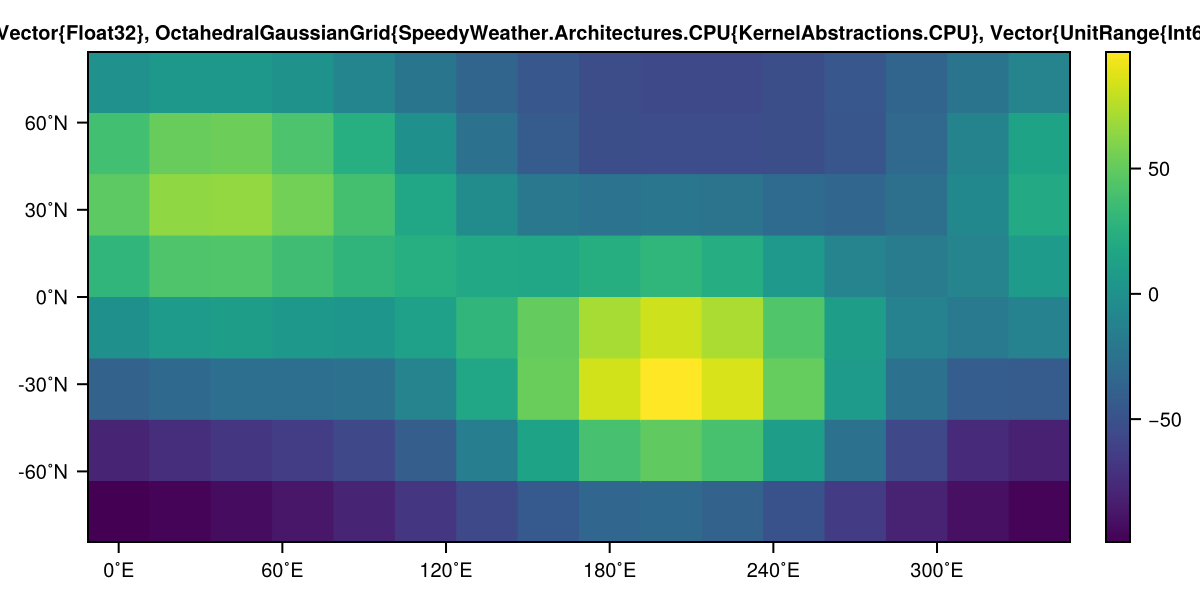

In [142]:
###FUNCTION for plotting ground truth without smooting

using SpeedyWeather.RingGrids
CM = CairoMakie

data = JLD2.load("../../run_0001/trunc5.jld2")

diag = data["output_vector"][385][2] ##385 is the first time step in x_test

vor_field = diag.grid.vor_grid[:, 1]

CM.heatmap(vor_field)


(96, 192, 1, 97)
(-98.97265290838433, 96.59999460569085)
(-98.97265290838433, 96.59999460569085)


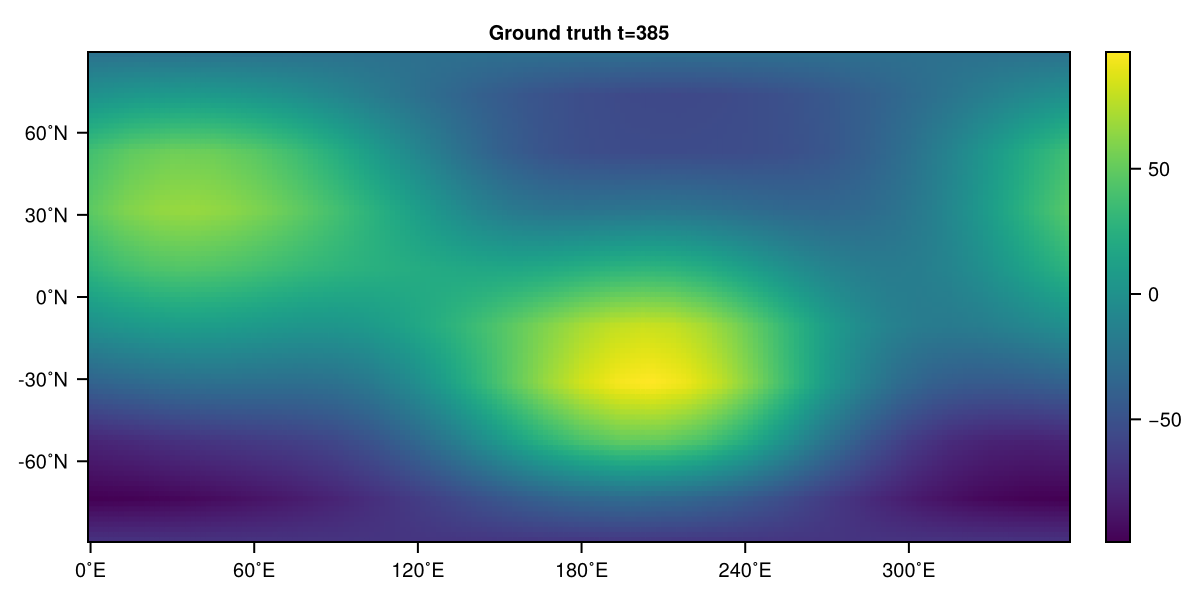

In [173]:
###FUNCTION for plotting ground truth of T5 data with smoothing

filepath = "fno_trunc_$(trunc).jld2"
@jldload filepath x_test y_test

vor_array = x_test[:, :, 1, 1]                     # vorticity at sample 1
println(size(x_test))               # should be (96,192,1,97)
println(extrema(x_test[:,:,1,1]))   # timestep 384
println(extrema(x_test[:,:,1, 1]))   # timestep 385
vor_field = FullGaussianGrid(vor_array, input_as=Matrix)
CM.heatmap(vor_field, title="Ground truth t=385")

(96, 192, 1, 97)


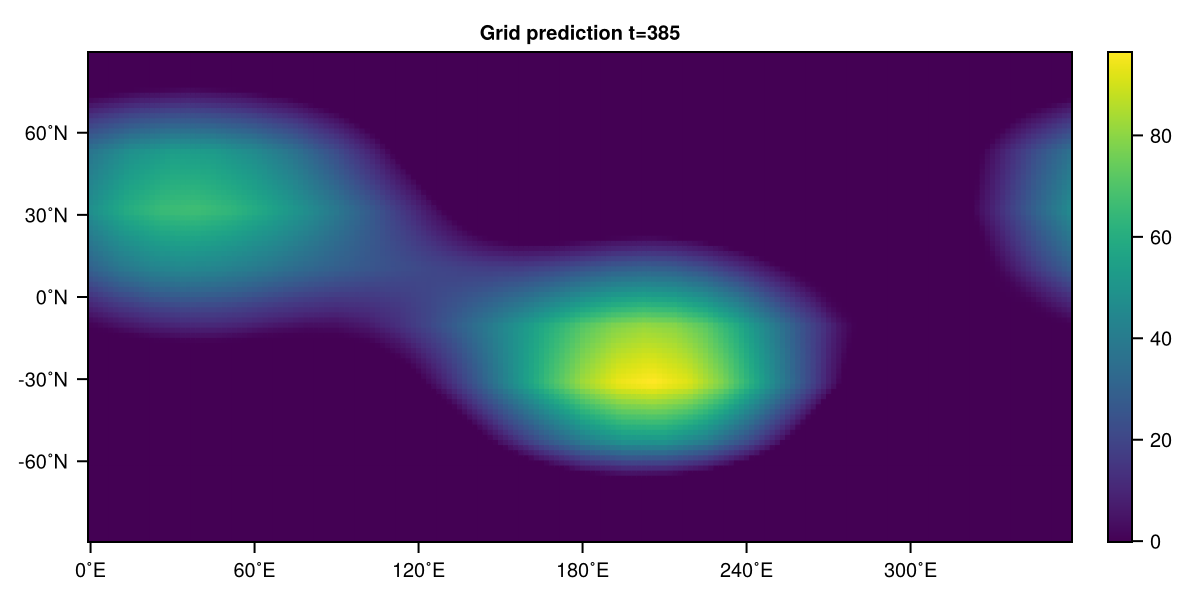

In [172]:
###FUNCTION for plotting prediction of T5 model on T5 data

CM = CairoMakie

filepath = "fno_trunc_$(trunc).jld2"
@jldload filepath x_test y_test 


@bsonload "fno_trunc_$(trunc)_cpu_150.bson" fno_cpu opt_state_cpu losses
pred = fno_cpu(x_test)
println(size(pred))

vor_array = pred[:, :, 1, 1]                     # vorticity at sample 1
vor_field = FullGaussianGrid(vor_array, input_as=Matrix)
CM.heatmap(vor_field, title="Grid prediction t=385")


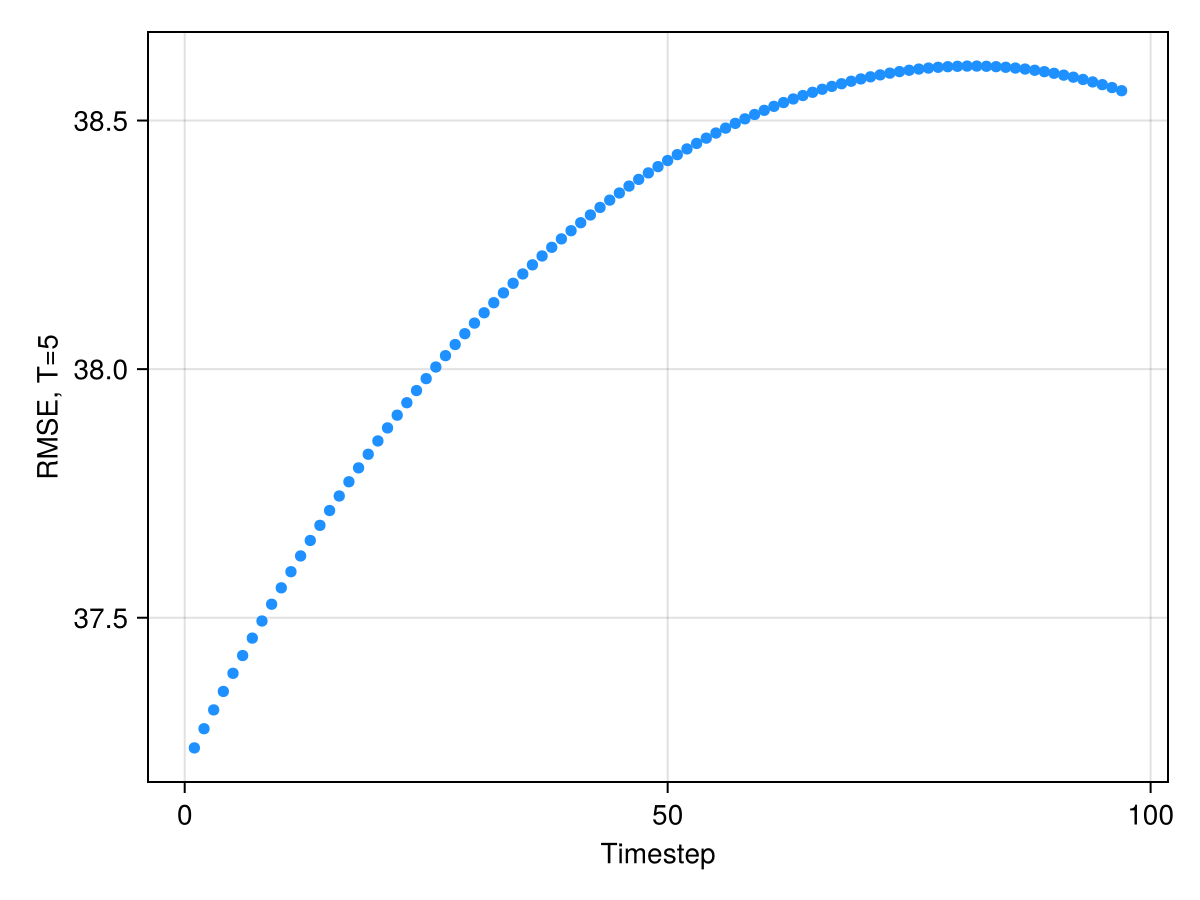

In [174]:
###FUNCTION for plotting individual RMSE of T5 model on T5 data

err = compute_error_fno(pred, x_test)

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="RMSE, T=5")
CM.scatter!(ax, 1:length(err), err; markersize=8, color=:dodgerblue)

fig

(96, 192, 1, 97)
(-263.1477020736941, 328.6076701774016)
(-263.1477020736941, 328.6076701774016)


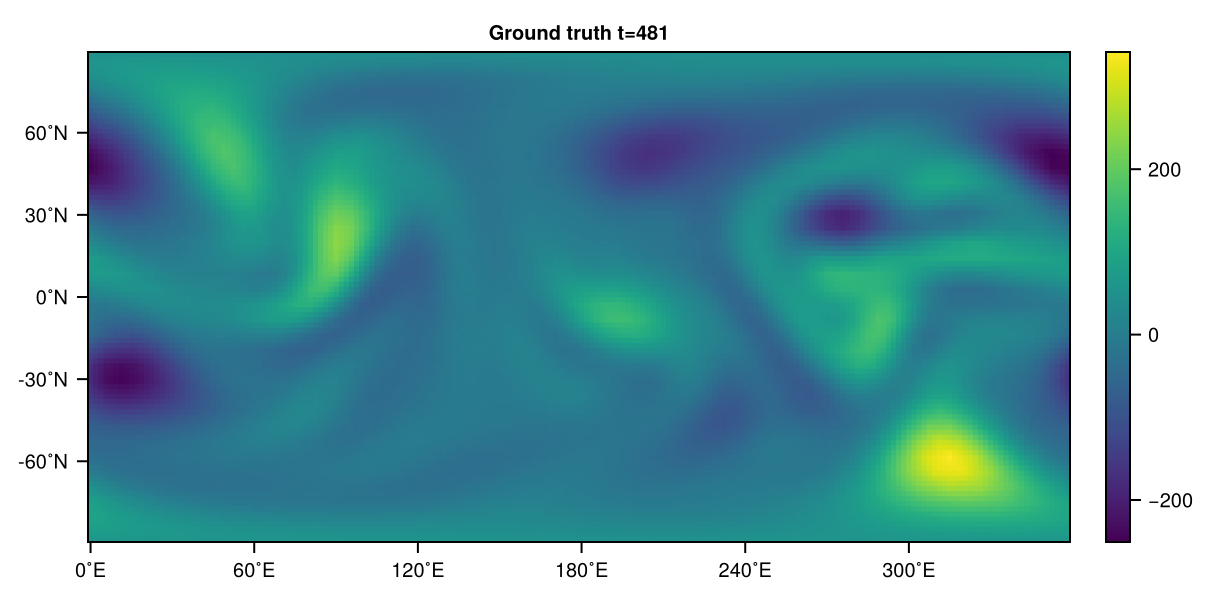

In [177]:
###FUNCTION for plotting ground truth of T20 data

filepath = "fno_trunc_20.jld2"
@jldload filepath x_test y_test

vor_array = x_test[:, :, 1, 97]                     # vorticity at sample 1
println(size(x_test))               # should be (96,192,1,97)
println(extrema(x_test[:,:,1,1]))   # timestep 384
println(extrema(x_test[:,:,1, 1]))   # timestep 385
vor_field = FullGaussianGrid(vor_array, input_as=Matrix)
CM.heatmap(vor_field, title="Ground truth t=481")

(96, 192, 1, 97)


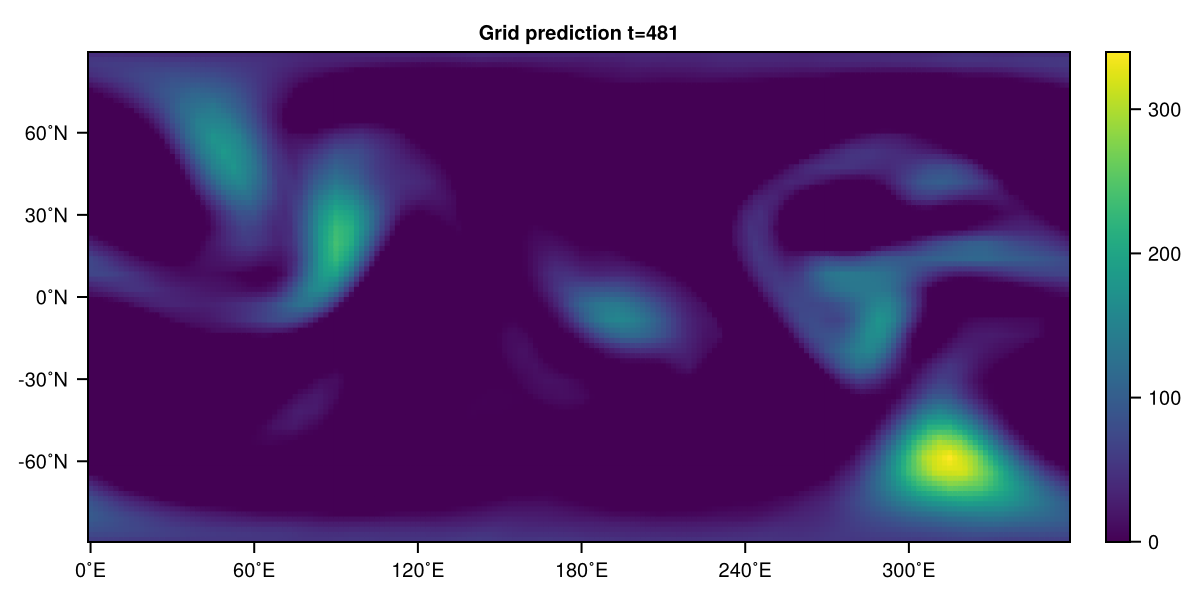

In [178]:
###FUNCTION for plotting prediction of T20 model on T20 data

CM = CairoMakie

filepath = "fno_trunc_20.jld2"
@jldload filepath x_test y_test 


@bsonload "fno_trunc_20_cpu_150.bson" fno_cpu opt_state_cpu losses
pred = fno_cpu(x_test)
println(size(pred))

vor_array = pred[:, :, 1, 97]                     # vorticity at sample 1
vor_field = FullGaussianGrid(vor_array, input_as=Matrix)
CM.heatmap(vor_field, title="Grid prediction t=481")


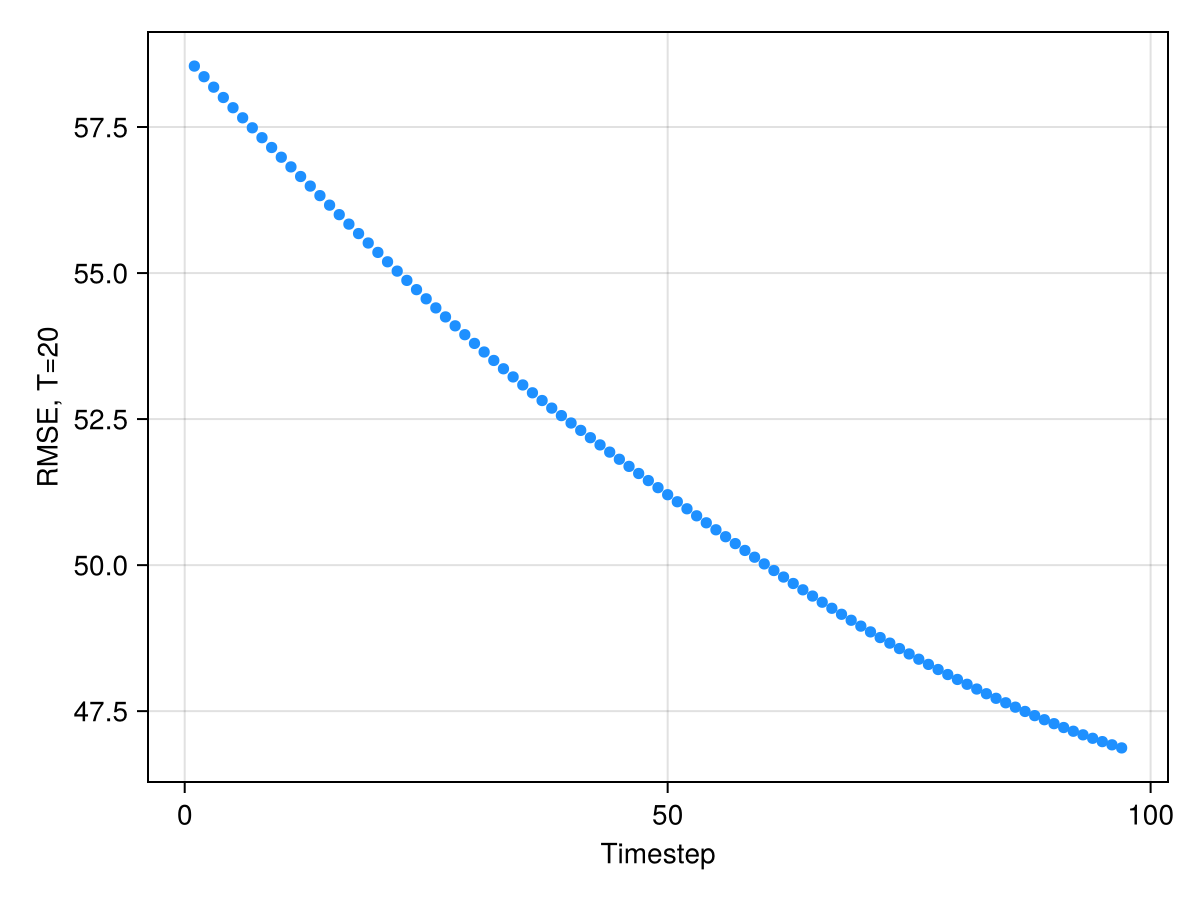

In [164]:
###FUNCTION for plotting individual RMSE of T20 model on T20 data

filepath = "marcelo_fno_trunc_20.jld2"
@jldload filepath x_test y_test 

@bsonload "marcelo_fno_trunc_20_cpu_150.bson" fno_cpu opt_state_cpu losses
pred = fno_cpu(x_test)

err = compute_error_fno(pred, x_test)

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="RMSE, T=20")
CM.scatter!(ax, 1:length(err), err; markersize=8, color=:dodgerblue)

fig

In [ ]:
###FUNCTION for plotting T5 model on T20 data

CM = CairoMakie

# Load test data from T20 
filepath = "fno_trunc_20.jld2"
@jldload filepath x_test y_test 

# Load T5 model
@bsonload "fno_trunc_5_cpu_150.bson" fno_cpu opt_state_cpu losses

# Forward pass through the model
pred = fno_cpu(x_test)
println(size(pred))   # should be (96, 192, channels, time)

# Extract vorticity channel, first test timestep
vor_array = pred[:, :, 1, 1]   
vor_field = FullGaussianGrid(vor_array, input_as=Matrix)

# Plot
CM.heatmap(vor_field, title="Grid prediction t=385")

In [ ]:
###FUNCTION for plotting all RMSE (T5 model on T5 data, T5 model on T20 data, T20 model on T20 data)

using BSON: @load as @bsonload 
using JLD2: @load as @jldload 

# --- T5 model on T5 data --- 
filepath5 = "marcelo_fno_trunc_5.jld2" 
@jldload filepath5 x_test y_test 
@bsonload "marcelo_fno_trunc_5_cpu_150.bson" fno_cpu opt_state_cpu losses p
red5 = fno_cpu(x_test) 
err5 = compute_error_fno(pred5, y_test) # compare against true trunc=5 data 

# --- T20 model on T20 data --- 
filepath20 = "marcelo_fno_trunc_20.jld2" 
@jldload filepath20 x_test y_test 
@bsonload "marcelo_fno_trunc_20_cpu_150.bson" fno_cpu opt_state_cpu losses 
pred20 = fno_cpu(x_test) 
err20 = compute_error_fno(pred20, y_test) # compare against true trunc=20 data 

# --- T5 model on T20 data --- 
filepath20 = "marcelo_fno_trunc_20.jld2" 
@jldload filepath20 x_test y_test 
@bsonload "marcelo_fno_trunc_5_cpu_150.bson" fno_cpu opt_state_cpu losses 
pred5_on_20 = fno_cpu(x_test) # apply trunc=5 model to trunc=20 test inputs 
err5_on_20 = compute_error_fno(pred5_on_20, y_test) 

fig = Figure(resolution=(800,500)) 
ax = Axis(fig[1, 1], xlabel = "Forecast step", ylabel = "RMSE", title = "RMSE Comparison") 

lines!(ax, 1:length(err5), err5; color = :dodgerblue, label = "T5 model on T5 data") 
lines!(ax, 1:length(err20), err20; color = :orange, label = "T20 model on T20 data") 
lines!(ax, 1:length(err5_on_20), err5_on_20; color = :green, label = "T5 model on T20 data") 
axislegend(ax; position = :rt) 
fig
